使用最小二乘对抗生成网络生成MNIST
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/MNIST/"
EPOCH = 100
GPU_NUMS = 1
BATCH_SIZE = 64
NOISE_DIM  = 62
IMAGE_CHANNEL = 1
IMAGE_SIZE = 28
LEARNING_RATE = 2e-4

In [2]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(NOISE_DIM, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU()
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 128 * 7 * 7),
            torch.nn.BatchNorm1d(128 * 7 * 7),
            torch.nn.ReLU()
        )

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, IMAGE_CHANNEL, 4, 2, 1),
            torch.nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, x):
        output = self.fc1(x)
        output = self.fc2(output)
        output = output.view(-1, 128, 7, 7)
        output = self.deconv1(output)
        output = self.deconv2(output)

        return output


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 4, 2, 1),
            torch.nn.LeakyReLU(0.2)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 4, 2, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2)
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128 * 7 * 7, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(0.2)
        )

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024, 1),
            torch.nn.Sigmoid()
        )
        initialize_weights(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = output.view(-1, 128 * 7 * 7)
        output = self.fc1(output)
        output = self.fc2(output)

        return output

# 3.导入数据

In [6]:
NetD = Discriminator()
NetG = Generator()
MSE_LOSS = torch.nn.MSELoss()

optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
trans=tv.transforms.Compose([tv.transforms.ToTensor()])
train_dataset = tv.datasets.MNIST(root=DATA_PATH,
                               train=True,
                               transform=trans,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
                          
fix_noise = torch.randn(100, NOISE_DIM)
fix_noise_var = torch.autograd.Variable(fix_noise)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    MSE_LOSS = MSE_LOSS.cuda()
    fix_noise_var = fix_noise_var.cuda()

# 4.训练

In [7]:
showbar = bar.ProgressBar(EPOCH, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCH + 1):
    NetG.train()
    for index, (image, label) in enumerate(train_loader):
        mini_batch = image.shape[0]
        noise = torch.rand(mini_batch, NOISE_DIM)

        real_var  = torch.autograd.Variable(image)
        noise_var = torch.autograd.Variable(noise)
        label_real_var = torch.autograd.Variable(torch.ones(mini_batch, 1 ))
        label_fake_var = torch.autograd.Variable(torch.zeros(mini_batch, 1))

        if torch.cuda.is_available():
            real_var = real_var.cuda()
            noise_var = noise_var.cuda()
            label_real_var = label_real_var.cuda()
            label_fake_var = label_fake_var.cuda()

        NetD.zero_grad()

        D_real = NetD(real_var)
        D_real_loss = MSE_LOSS(D_real, label_real_var)

        G_ = NetG(noise_var)
        D_fake = NetD(G_)
        D_fake_loss = MSE_LOSS(D_fake, label_fake_var)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        optimizerD.step()

        NetG.zero_grad()

        G_ = NetG(noise_var)
        D_fake = NetD(G_)
        G_loss = MSE_LOSS(D_fake, label_real_var)

        G_loss.backward()
        optimizerG.step()

        showbar.show(epoch, D_loss.item(), G_loss.item())

Epoch:1 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.307;G Loss:0.480,total=0:00:570
Epoch:2 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.325;G Loss:0.491,total=0:00:570
Epoch:3 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.281;G Loss:0.540,total=0:00:57041:57
Epoch:4 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.364;G Loss:0.469,total=0:00:570:43:33
Epoch:5 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.394;G Loss:0.425,total=0:00:57022:1641
Epoch:6 / 100 [******************************************************************************************************

Epoch:46 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.215;G Loss:0.662,total=0:00:570:24:3343
Epoch:47 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.039;G Loss:0.835,total=0:00:570:02:0801
Epoch:48 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.053;G Loss:0.928,total=0:00:560:33:3002
Epoch:49 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.081;G Loss:0.871,total=0:00:570:10:5063
Epoch:50 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.079;G Loss:0.923,total=0:00:570:41:0822
Epoch:51 / 100 [**************************************************************************

Epoch:91 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.237;G Loss:0.840,total=0:00:570912:3817
Epoch:92 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.102;G Loss:0.783,total=0:00:570328:4521
Epoch:93 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.021;G Loss:0.948,total=0:00:570215:4046
Epoch:94 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.062;G Loss:0.964,total=0:00:570803:0116
Epoch:95 / 100 [********************************************************************************************************] 938 / 938 ,D Loss:0.075;G Loss:0.948,total=0:00:570418:2935
Epoch:96 / 100 [**************************************************************************

# 5.生成数据

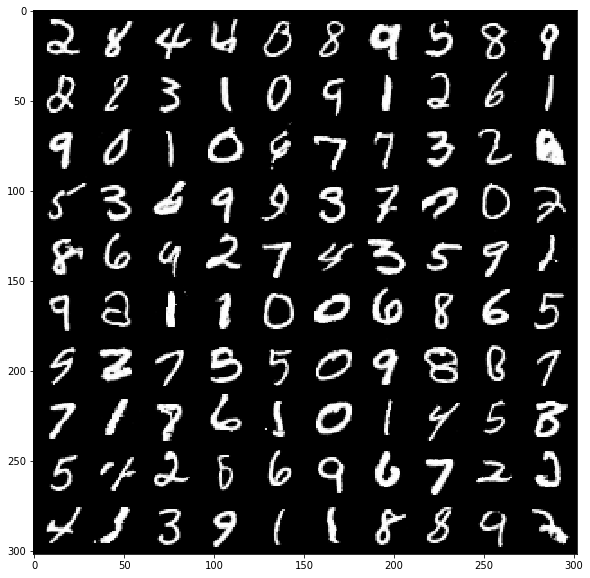

In [8]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))